In [32]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
import data, viz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all models

In [17]:
def load_results(out_dir):
    r = []
    for fname in os.listdir(out_dir):
        d = pkl.load(open(oj(out_dir, fname), 'rb'))
        metrics = {k: d['cv'][k] for k in d['cv'].keys() if not 'curve' in k}
        out = {k: np.mean(metrics[k]) for k in metrics}
        out.update({k + '_std': np.std(metrics[k]) for k in metrics})
        out['model_type'] = fname.replace('.pkl', '') #d['model_type']
        
        imp_mat = np.array(d['imps']['imps'])
        imp_mu = imp_mat.mean(axis=0)
        imp_sd = imp_mat.std(axis=0)
        
        feat_names = d['feat_names']
        out.update({feat_names[i] + '_f': imp_mu[i] for i in range(len(feat_names))})
        out.update({feat_names[i]+'_std_f': imp_sd[i] for i in range(len(feat_names))})
        r.append(pd.Series(out))
    r = pd.concat(r, axis=1, sort=False).T.infer_objects()
    r = r.reindex(sorted(r.columns, reverse=True), axis=1) # sort the column names
    r = r.round(3)
    r = r.set_index('model_type')
    return r
out_dir = 'results/outcome=iai_intervention'
results = load_results(out_dir)

**look at prediction metrics**

In [18]:
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values('balanced_accuracy', ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r.style.background_gradient(cmap='viridis', axis=0) # columns differently colored
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])

,specificity,sensitivity,roc_auc,precision,f1,balanced_accuracy,accuracy
model_type,,,,,,,
logistic_20_ros,0.984,0.818,0.87,0.078,0.143,0.829,0.839
logistic_30_ros,0.985,0.789,0.868,0.082,0.148,0.821,0.851
logistic_52_ros,0.985,0.78,0.856,0.084,0.152,0.819,0.857
logistic_10_ros,0.983,0.817,0.856,0.07,0.129,0.816,0.815
gb_52_ros,0.986,0.731,0.873,0.096,0.17,0.808,0.883
gb_20_ros,0.986,0.734,0.874,0.092,0.164,0.806,0.876
gb_30_ros,0.986,0.731,0.87,0.092,0.163,0.805,0.877
gb_10_ros,0.986,0.718,0.815,0.078,0.14,0.786,0.852
logistic_5_ros,0.988,0.65,0.794,0.09,0.158,0.77,0.887


**look at feat importances**

In [20]:
r = results
print(r.keys())
# r.style.apply(viz.highlight_max, subset=[k for k in r if not 'std' in k])
r = r.sort_values('balanced_accuracy', ascending=False)
keys = [k for k in r if '_f' in k]
keys_remapped = {k: k.replace('_f', '') for k in keys}
r = r[keys].rename(columns=keys_remapped)
# r = r.sort_values('lifetime')
# r = r[r.index.str.contains('35')]
# r = r[r.index.str.contains('11')]
# r = r.rename(columns={'mean_square_displacement': 'msd', 'total_displacement': 'td'})

r = r[r.index.str.contains('52')]
r = r[[k for k in r if not 'std' in k]]


def rank(r):
    '''Rank feature importances appropriately
    '''
    r = r.abs()
    r = r.rank(axis=1, ascending=False, method='min')
    return r
# 
r = rank(r)
r = r.reindex(r.mean().sort_values(ascending=True).index, axis=1) # sort cols by mean rank
idxs = r.index
r.insert(0, 'acc', results.loc[idxs]['accuracy'])

subset = list(r.keys())
subset.remove('acc')
r.fillna(0).style.background_gradient(cmap='viridis_r', axis=1, subset=subset) # rows differently colored

Index(['specificity_std', 'specificity', 'sensitivity_std', 'sensitivity',
       'roc_auc_std', 'roc_auc', 'precision_std', 'precision', 'f1_std', 'f1',
       ...
       'AbdTenderDegree_1_1.0_std_f', 'AbdTenderDegree_1_1.0_f',
       'AbdDistention_1_4_std_f', 'AbdDistention_1_4_f',
       'AbdDistention_1_3_std_f', 'AbdDistention_1_3_f',
       'AbdDistention_1_2_std_f', 'AbdDistention_1_2_f',
       'AbdDistention_1_1_std_f', 'AbdDistention_1_1_f'],
      dtype='object', length=118)


,acc,AbdTenderDegree_1_3.0,AbdTrauma_1_2,GCSScore_1,AbdomenPain_1_2,AbdDistention_1_1,ThoracicTender_1_3,AbdTrauma_1_1,AbdTenderDegree_1_nan,RecodedMOI_1_1,AbdTrauma_or_SeatBeltSign_1_False,ThoracicTender_1_1,DecrBreathSound_1_1,AbdTenderDegree_1_2.0,AbdomenPain_1_1,VomitWretch_1_1,DistractingPain_1_1,RecodedMOI_1_2,ThoracicTrauma_1_1,SeatBeltSign_1_1,DistractingPain_1_2,ThoracicTender_1_2,RecodedMOI_1_5,AbdDistention_1_4,AbdTenderDegree_1_1.0,AbdTrauma_1_4,RecodedMOI_1_7,RecodedMOI_1_9,VomitWretch_1_2,DecrBreathSound_1_4,RecodedMOI_1_3,ThoracicTrauma_1_2,SeatBeltSign_1_2,AbdomenPain_1_4,ThoracicTrauma_1_3,AbdomenPain_1_3,AbdTenderDegree_1_4.0,AbdTrauma_or_SeatBeltSign_1_True,RecodedMOI_1_6,RecodedMOI_1_4,RecodedMOI_1_8,RecodedMOI_1_10,ThoracicTender_1_4,VomitWretch_1_3,DecrBreathSound_1_2,AbdDistention_1_2,SeatBeltSign_1_3,AbdDistention_1_3,DistractingPain_1_3,DistractingPain_1_4,DecrBreathSound_1_3,VomitWretch_1_4,AbdTrauma_1_3
model_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
logistic_52_ros,0.857,3,6,8,22,10,18,1,14,21,15,24,17,19,25,28,30,38,22,35,32,34,33,10,51,2,26,9,36,7,20,43,37,13,4,27,5,15,39,45,31,12,29,41,40,52,49,50,46,44,47,48,42
gb_52_ros,0.883,4,3,8,1,14,10,4,6,14,10,14,29,9,2,14,14,14,14,14,14,14,10,14,7,29,29,29,14,29,14,14,10,29,29,14,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
dt_52_ros,0.928,4,3,2,1,5,9,33,21,9,20,8,6,26,28,14,14,7,24,12,16,16,21,41,11,41,18,36,24,39,41,21,33,39,49,41,49,41,18,13,27,49,33,28,36,28,31,31,36,41,41,41,49


# analyze individual model

In [25]:
# prep the dataframe
df = data.get_features() # uses several forms
df = data.rename_values(df) # rename features based on their meaning
df = data.preprocess(df) # preprocess the feats

# convert feats to dummy
df = pd.get_dummies(df, dummy_na=True) # treat na as a separate category
df = data.remove_zero_cols(df) # remove any cols that are all zero

outcomes = data.get_outcomes() # 2 outcomes: iai, and iai_intervention
df = pd.merge(df, outcomes, on='id', how='left')


# set up train / test
np.random.seed(42)
df['cv_fold'] = np.random.randint(1, 7, size=df.shape[0]) # 6 is the test set

# feats / outcome keys
feat_names = [k for k in df.keys() if not k in ['id', 'cv_fold'] and not 'IAI' in k]
outcome_def = 'iai_intervention'

100%|██████████| 49/49 [00:02<00:00, 21.29it/s]
48it [00:07,  5.83it/s]


final shape (12044, 433)


In [36]:
idxs_test = df.cv_fold.isin([6])
X_test, Y_test = df[idxs_test], df[outcome_def][idxs_test]

In [ ]:
def count_common_feats(m_cv, model_type='tree'):
    if model_type == 'tree':
        feats_used = []
        for i in range(len(m_cv['estimator'])):
            m_fit = m_cv['estimator'][i]
            feats_used += list(ks[m_fit.feature_importances_ != 0])
    elif model_type == 'logistic':
        feats_used = []
        for i in range(len(m_cv['estimator'])):
            m_fit = m_cv['estimator'][i]
            num_feats = 5
            # get top num_feats features with biggest bsolute weights
            idxs = np.abs(m_fit.coef_).flatten().argsort()[-num_feats:][::-1]
            feats_used += list(ks[idxs])
    return sorted(dict(Counter(feats_used)).items(), key=lambda kv: kv[1], reverse=True)
        
count_common_feats(m_cv, model_type)

In [ ]:
# plot a tree
m_fit = m_cv['estimator'][0]
plt.figure(dpi=300)
plot_tree(m_fit, feature_names=ks)
plt.show()

# misc funcs...

metric                   	validation
balanced_accuracy        	0.829 ~ 0.043
accuracy                 	0.839 ~ 0.009
precision                	0.078 ~ 0.012
sensitivity              	0.818 ~ 0.085
specificity              	0.984 ~ 0.003
f1                       	0.143 ~ 0.020
roc_auc                  	0.870 ~ 0.047

feature importances
DistractingPain_1_4      	-0.054 ~ 0.305
ThoracicTender_1_3       	0.702 ~ 0.055
RecodedMOI_1_2           	-0.133 ~ 0.067
RecodedMOI_1_4           	-0.113 ~ 0.047
AbdTenderDegree_1_3.0    	0.658 ~ 0.034
AbdDistention_1_3        	-0.256 ~ 0.120
AbdTrauma_1_2            	-0.492 ~ 0.039
ThoracicTender_1_1       	0.086 ~ 0.072
AbdDistention_1_2        	-0.498 ~ 0.051
SeatBeltSign_1_2         	-0.061 ~ 0.044
RecodedMOI_1_3           	-0.250 ~ 0.052
AbdTenderDegree_1_2.0    	0.465 ~ 0.082
VomitWretch_1_2          	-0.256 ~ 0.080
AbdTenderDegree_1_4.0    	-0.444 ~ 0.030
RecodedMOI_1_7           	-0.327 ~ 0.038
VomitWretch_1_3          	-0.038 ~ 0.053
RecodedMOI

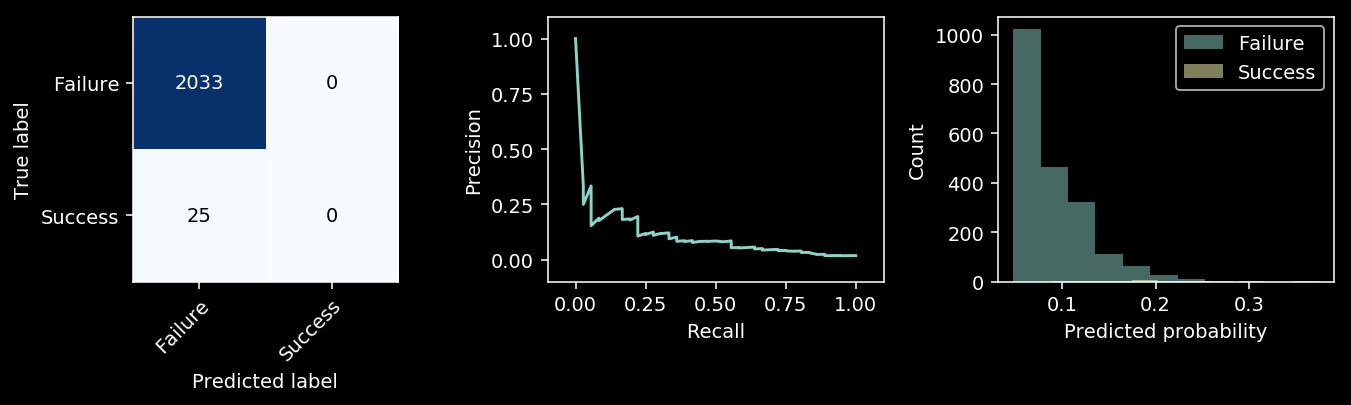

In [41]:
def visualize_individual_results(results):
    scores_cv = results['cv']
    scores_test = results['test']
    imps = results['imps']
    m = imps['model'][0]
    print(Fore.CYAN + f'{"metric":<25}\tvalidation') #\ttest')
    for s in results['metrics']:
        if not 'curve' in s:
            print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}')
    #         print(Fore.WHITE + f'{s:<25}\t{np.mean(scores_cv[s]):.3f} ~ {np.std(scores_cv[s]):.3f}\t{np.mean(scores_test[s]):.3f} ~ {np.std(scores_test[s]):.3f}')

    print(Fore.CYAN + '\nfeature importances')
    imp_mat = np.array(imps['imps'])
    imp_mu = imp_mat.mean(axis=0)
    imp_sd = imp_mat.std(axis=0)
    for i, feat_name in enumerate(results['feat_names']):
        print(Fore.WHITE + f'{feat_name:<25}\t{imp_mu[i]:.3f} ~ {imp_sd[i]:.3f}')

    # print(m.coef_)
    plt.figure(figsize=(10, 3), dpi=140)
    R, C = 1, 3
    plt.subplot(R, C, 1)
    # print(X_test.shape, results['feat_names'])
    preds = m.predict(X_test[results['feat_names']])
    preds_proba = m.predict_proba(X_test[results['feat_names']])[:, 1]    
    viz.plot_confusion_matrix(Y_test, preds, classes=np.array(['Failure', 'Success']))

    plt.subplot(R, C, 2)
    prec, rec, thresh = scores_test['precision_recall_curve'][0]
    plt.plot(rec, prec)
    plt.xlim((-0.1, 1.1))
    plt.ylim((-0.1, 1.1))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    
    
    plt.subplot(R, C, 3)
    plt.hist(preds_proba[Y_test==0], alpha=0.5, label='Failure')
    plt.hist(preds_proba[Y_test==1], alpha=0.5, label='Success')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return preds, preds_proba

# results = pkl.load(open('results/classify_outcome=y_consec_sig/rf_ros_11.pkl', 'rb'))
results = pkl.load(open('results/outcome=iai_intervention/logistic_20_ros.pkl', 'rb'))
preds, preds_proba = visualize_individual_results(results)